# Pretrained Models Notebook



# Importing Packages

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG19

from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [17]:
cnn_base = ResNet50(include_top = False,
                    weights = "imagenet",
                    input_shape = (256, 256, 3))
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))

cnn_base.trainable = False

In [3]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [19]:
X_test, y_test = next(test_generator)

In [20]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [21]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
tensorboard_cb = TensorBoard(log_dir = "../logresnet")
csv_logger = CSVLogger('../logresnet/log.csv')
history = model.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   epochs = 20,
                   callbacks = [earlyStopping, mcp_save, tensorboard_cb, csv_logger],
                   validation_data = val_generator,
                   validation_steps = len(val_generator))

Epoch 1/20
428/428 [==============================] - 1514s 4s/step - loss: 0.7918 - accuracy: 0.7660 - precision_2: 0.7871 - recall_2: 0.9498 - auc_4: 0.6465 - auc_5: 0.8211 - val_loss: 0.3992 - val_accuracy: 0.8645 - val_precision_2: 0.8645 - val_recall_2: 1.0000 - val_auc_4: 0.5000 - val_auc_5: 0.8645
Epoch 2/20
428/428 [==============================] - 1463s 3s/step - loss: 0.4217 - accuracy: 0.8447 - precision_2: 0.8317 - recall_2: 0.9990 - auc_4: 0.6922 - auc_5: 0.8458 - val_loss: 0.4295 - val_accuracy: 0.8619 - val_precision_2: 0.8642 - val_recall_2: 0.9969 - val_auc_4: 0.4973 - val_auc_5: 0.8639
Epoch 3/20
428/428 [==============================] - 1474s 3s/step - loss: 0.4469 - accuracy: 0.8306 - precision_2: 0.8179 - recall_2: 0.9993 - auc_4: 0.6669 - auc_5: 0.8262 - val_loss: 0.4079 - val_accuracy: 0.8645 - val_precision_2: 0.8645 - val_recall_2: 1.0000 - val_auc_4: 0.5000 - val_auc_5: 0.8645
Epoch 4/20
428/428 [==============================] - 1460s 3s/step - loss: 0.4139

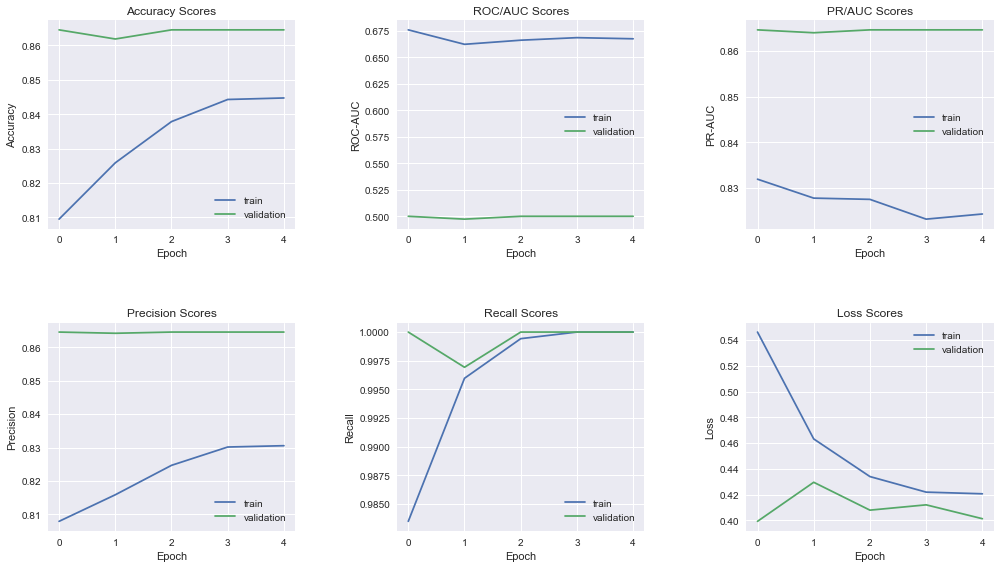

In [22]:
plt.style.use('seaborn')
sixplot(history, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

In [23]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision_2,recall_2,auc_4,auc_5,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_4,val_auc_5
0,0.546174,0.809503,0.807953,0.983481,0.676034,0.831963,0.399194,0.864542,0.864542,1.000000,0.500000,0.864542
1,0.463182,0.825877,0.815893,0.995966,0.662395,0.827831,0.429523,0.861886,0.864181,0.996928,0.497312,0.863911
2,0.433958,0.837865,0.824695,0.999424,0.666273,0.827560,0.407883,0.864542,0.864542,1.000000,0.500000,0.864542
3,0.421874,0.844298,0.830171,1.000000,0.668673,0.823247,0.412002,0.864542,0.864542,1.000000,0.500000,0.864542
4,0.420579,0.844737,0.830568,1.000000,0.667614,0.824367,0.401238,0.864542,0.864542,1.000000,0.500000,0.864542


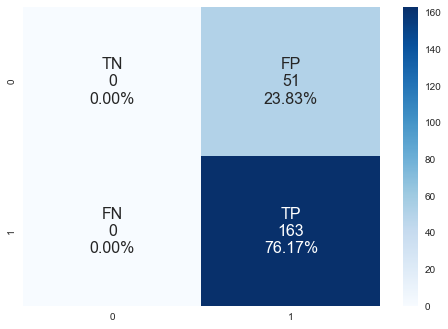

In [24]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [10]:
model2 = AlexNet()
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [11]:
filepath = '../models/Alexnet.h5'
# earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
tensorboard_cb = TensorBoard(log_dir = "../logalexnet")
csv_logger = CSVLogger('../logalexnet/log.csv')
history2 = model2.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger],
                     validation_data = val_generator,
                     validation_steps = len(val_generator))


Epoch 1/20
428/428 [==============================] - 2237s 5s/step - loss: 4.8319 - accuracy: 0.8199 - precision_1: 0.8788 - recall_1: 0.8852 - auc_2: 0.7999 - auc_3: 0.9001 - val_loss: 0.7042 - val_accuracy: 0.8971 - val_precision_1: 0.8991 - val_recall_1: 0.9923 - val_auc_2: 0.8036 - val_auc_3: 0.9438
Epoch 2/20
428/428 [==============================] - 1887s 4s/step - loss: 0.3733 - accuracy: 0.8950 - precision_1: 0.9195 - recall_1: 0.9461 - auc_2: 0.9310 - auc_3: 0.9716 - val_loss: 0.3571 - val_accuracy: 0.8639 - val_precision_1: 0.9644 - val_recall_1: 0.8748 - val_auc_2: 0.9132 - val_auc_3: 0.9829
Epoch 3/20
428/428 [==============================] - 2318s 5s/step - loss: 0.3224 - accuracy: 0.9007 - precision_1: 0.9115 - recall_1: 0.9631 - auc_2: 0.9334 - auc_3: 0.9719 - val_loss: 0.2791 - val_accuracy: 0.8831 - val_precision_1: 0.8976 - val_recall_1: 0.9762 - val_auc_2: 0.8883 - val_auc_3: 0.9800
Epoch 4/20
428/428 [==============================] - 2208s 5s/step - loss: 0.3299

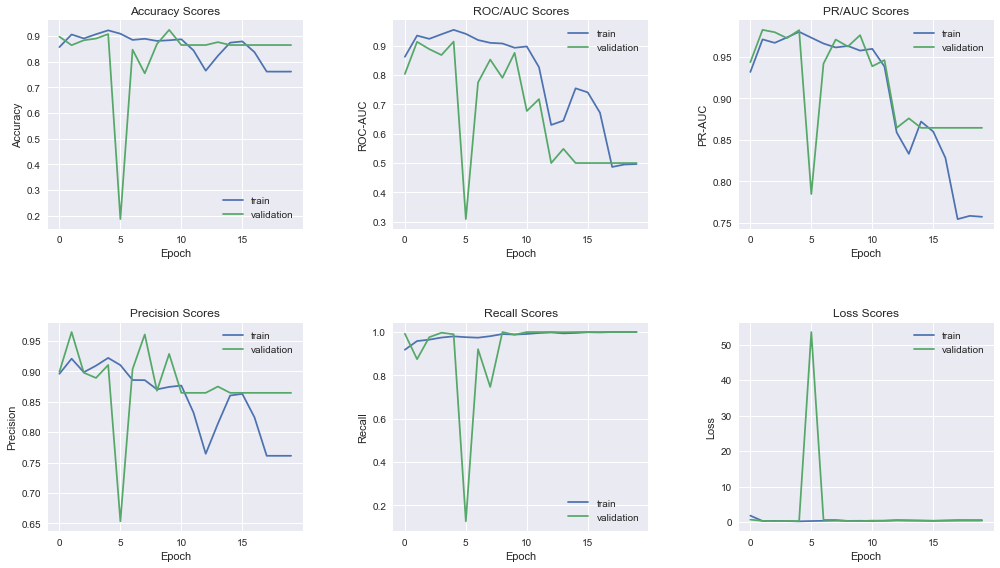

In [12]:
plt.style.use('seaborn')
sixplot(history2, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [13]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_1,recall_1,auc_2,auc_3,val_loss,val_accuracy,val_precision_1,val_recall_1,val_auc_2,val_auc_3
0,1.833581,0.856579,0.895822,0.918363,0.862187,0.932021,0.704193,0.897078,0.899095,0.992320,0.803632,0.943794
1,0.319386,0.905556,0.920664,0.958509,0.934487,0.971394,0.357056,0.863878,0.964437,0.874808,0.913210,0.982898
2,0.360528,0.890205,0.898408,0.964848,0.923366,0.967226,0.279146,0.883134,0.897599,0.976190,0.888324,0.980037
3,0.297067,0.906579,0.909156,0.974645,0.938946,0.973697,0.333639,0.889774,0.889041,0.996928,0.868189,0.972970
4,0.230119,0.921784,0.921951,0.980215,0.953992,0.980548,0.261197,0.907039,0.910311,0.990015,0.913933,0.982564
5,0.314048,0.908626,0.910116,0.976373,0.940407,0.973446,53.520088,0.186587,0.653386,0.125960,0.308748,0.784530
6,0.378130,0.884503,0.885610,0.974068,0.919337,0.966392,0.639265,0.846614,0.903542,0.920891,0.774691,0.942110
7,0.426955,0.888889,0.885402,0.980983,0.909779,0.961635,0.646014,0.754316,0.960474,0.746544,0.852589,0.971209
8,0.359017,0.880556,0.870255,0.990780,0.907520,0.963451,0.327494,0.868526,0.868000,1.000000,0.790541,0.962784
9,0.378795,0.883187,0.874299,0.988667,0.892979,0.957832,0.294092,0.923639,0.928520,0.987711,0.875648,0.976490


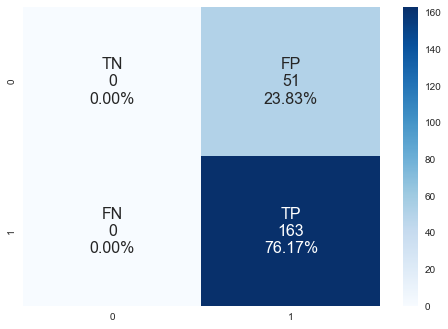

In [14]:
prob = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5
make_confusion_matrix(y_true, y_pred2)

In [15]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (227, 227),
        batch_size = 214,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

X_test, y_test = next(test_generator)

Found 214 images belonging to 2 classes.


In [16]:
score = model2.evaluate(X_test, y_test, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

7/7 [==============================] - 2s 246ms/step - loss: 0.5493 - accuracy: 0.7617 - precision_1: 0.7617 - recall_1: 1.0000 - auc_2: 0.5000 - auc_3: 0.7617
loss: 0.549328625202179
accuracy: 0.7616822719573975


# VGG19

In [22]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 753,
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [23]:
vgg19 = VGG19(include_top = False, 
              weights = 'imagenet', 
              input_shape = (224, 224, 3))

model3 = models.Sequential()
model3.add(vgg19)
model3.add(layers.Flatten())
model3.add(layers.Dense(132, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

vgg19.trainable = False

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

model3.compile(optimizer = Adam(lr=0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

vgg19 True
4
flatten_4 True
4
dense_7 True
4
dense_8 True
4
vgg19 False
4
flatten_4 True
4
dense_7 True
4
dense_8 True
4


In [24]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
mcp_save = ModelCheckpoint('../models/VGG19.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min')
tensorboard_cb = TensorBoard(log_dir="../logvgg19")
csv_logger = CSVLogger('../logvgg19/log.csv')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 10)

Epoch 1/20
684/684 [==============================] - 2555s 4s/step - loss: 0.4027 - acc: 0.9057 - auc_6: 0.9095 - auc_7: 0.9494 - precision_3: 0.9296 - recall_3: 0.9454 - val_loss: 0.2255 - val_acc: 0.9256 - val_auc_6: 0.9456 - val_auc_7: 0.9884 - val_precision_3: 0.9700 - val_recall_3: 0.9432
Epoch 2/20
684/684 [==============================] - 1863s 3s/step - loss: 0.1558 - acc: 0.9512 - auc_6: 0.9681 - auc_7: 0.9832 - precision_3: 0.9550 - recall_3: 0.9821 - val_loss: 0.1815 - val_acc: 0.9376 - val_auc_6: 0.9544 - val_auc_7: 0.9890 - val_precision_3: 0.9428 - val_recall_3: 0.9877
Epoch 3/20
684/684 [==============================] - 1651s 2s/step - loss: 0.1193 - acc: 0.9586 - auc_6: 0.9818 - auc_7: 0.9927 - precision_3: 0.9602 - recall_3: 0.9869 - val_loss: 0.2088 - val_acc: 0.9256 - val_auc_6: 0.9623 - val_auc_7: 0.9907 - val_precision_3: 0.9775 - val_recall_3: 0.9355
Epoch 4/20
684/684 [==============================] - 1600s 2s/step - loss: 0.1150 - acc: 0.9586 - auc_6: 0.9824

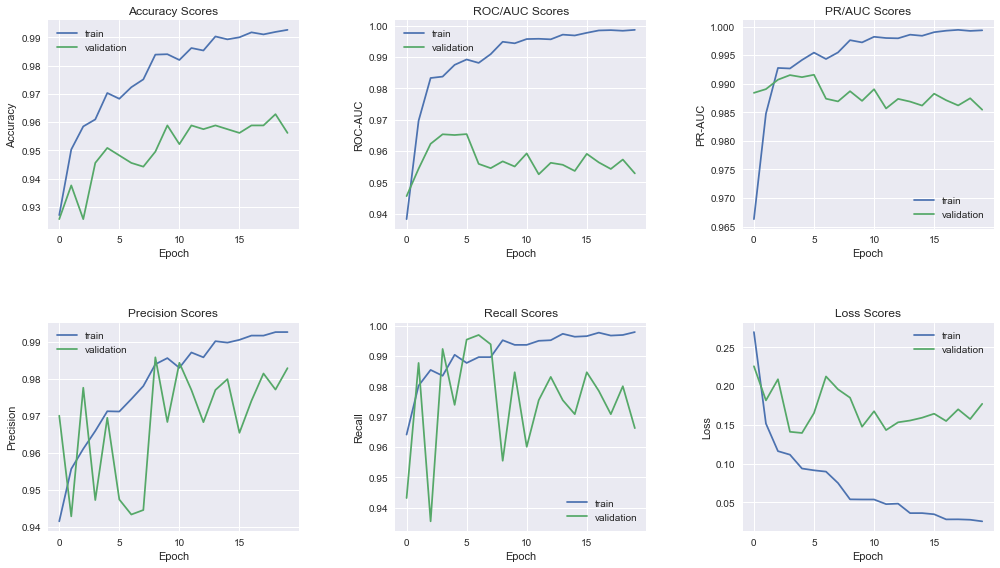

In [27]:
plt.style.use('seaborn')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [28]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,acc,auc_6,auc_7,precision_3,recall_3,val_loss,val_acc,val_auc_6,val_auc_7,val_precision_3,val_recall_3,lr
0,0.269627,0.927047,0.938315,0.966305,0.941474,0.964080,0.225523,0.925631,0.945649,0.988398,0.969984,0.943164,0.001000
1,0.151580,0.950292,0.969664,0.984754,0.955618,0.980215,0.181507,0.937583,0.954384,0.989048,0.942815,0.987711,0.001000
2,0.115991,0.958480,0.983305,0.992752,0.961034,0.985401,0.208755,0.925631,0.962328,0.990697,0.977528,0.935484,0.001000
3,0.111437,0.960965,0.983751,0.992659,0.965855,0.983481,0.140972,0.945551,0.965362,0.991503,0.947214,0.992320,0.001000
4,0.093593,0.970322,0.987496,0.994144,0.971181,0.990396,0.139445,0.950863,0.965129,0.991145,0.969419,0.973886,0.001000
5,0.091284,0.968275,0.989212,0.995435,0.971105,0.987706,0.165091,0.948207,0.965423,0.991560,0.947368,0.995392,0.001000
6,0.089581,0.972368,0.988120,0.994316,0.974466,0.989627,0.212341,0.945551,0.955927,0.987372,0.943314,0.996928,0.001000
7,0.074839,0.975146,0.990905,0.995469,0.977980,0.989627,0.195748,0.944223,0.954565,0.986899,0.944526,0.993856,0.001000
8,0.053829,0.983918,0.994855,0.997613,0.983859,0.995198,0.184981,0.949535,0.956733,0.988683,0.985737,0.955453,0.000500
9,0.053655,0.984064,0.994368,0.997220,0.985521,0.993661,0.147498,0.958831,0.955092,0.986995,0.968278,0.984639,0.000500


In [38]:
hist_df_3.to_csv('../data/vgg19.csv')

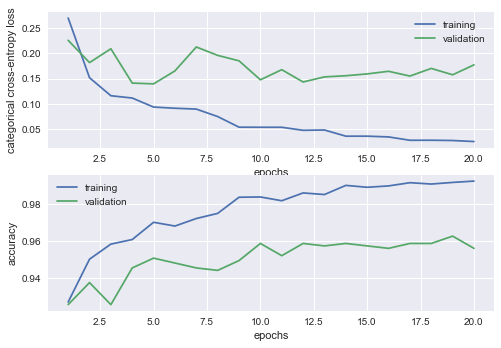

In [31]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

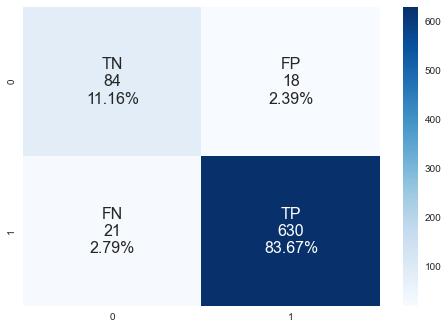

In [32]:
prob3 = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred3)

In [33]:
X_tt, y_tt = next(test_generator)
score = model3.evaluate(X_tt, y_tt, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

24/24 [==============================] - 102s 4s/step - loss: 0.1677 - acc: 0.9482 - auc_6: 0.9490 - auc_7: 0.9858 - precision_3: 0.9722 - recall_3: 0.9677
loss: 0.16768935322761536
acc: 0.9482071995735168


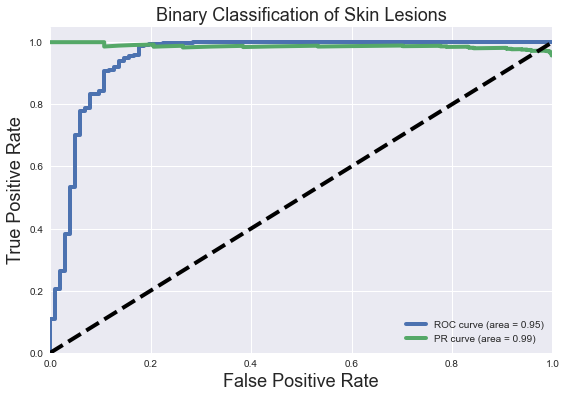

In [36]:
y_score = model3.predict_proba(X_tt)
fpr, tpr, __ = roc_curve(y_tt, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_tt, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()